---
```
Class: DPCV - SDH@HK242 - HCMUT
Name: Nguyễn Lê Nhật Minh
Exercise: 02

```
---

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score

In [5]:
# Tải dataset từ file .npy.
# https://drive.google.com/file/d/1ZgUIHN-tM2-W3zfKZnRA0jsq_EDyfxKm/view?usp=sharing
fer13_path = "./datasets/fer13_v2.npy"
data = np.load(fer13_path, allow_pickle=True).item()

x_train, y_train = data["train"]
x_val, y_val = data["val"]
x_test, y_test = data["test"]

# Kiểm tra kích thước dữ liệu
print(f"Train: {x_train.shape}, {y_train.shape}")
print(f"Val: {x_val.shape}, {y_val.shape}")
print(f"Test: {x_test.shape}, {y_test.shape}")

Train: (28709, 48, 48), (28709,)
Val: (3589, 48, 48), (3589,)
Test: (3589, 48, 48), (3589,)


In [6]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Chuyển ảnh xám thành 3 kênh
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Chuẩn hóa 3 kênh
])

In [7]:
class FERDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images.astype(np.uint8)  # Chuyển về kiểu uint8
        self.labels = labels.astype(np.int64)  # Chuyển về kiểu int64
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)  # Đảm bảo label là torch.long

In [8]:
# Tạo DataLoader
train_dataset = FERDataset(x_train, y_train, transform=transform)
val_dataset = FERDataset(x_val, y_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load mô hình ResNet18 đã pretrained trên ImageNet
model = models.resnet18(pretrained=True)

# Thay thế fully connected layer cho bài toán classification với số lớp tương ứng
num_ftrs = model.fc.in_features
num_classes = len(np.unique(y_train))  # Xác định số lượng class từ dữ liệu
model.fc = nn.Linear(num_ftrs, num_classes)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ADMIN/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 20.0MB/s]


In [9]:
# Hàm huấn luyện
def train_model(model, optimizer, criterion, num_epochs=10):
    history = {"train_acc": [], "val_acc": [], "f1": []}

    for epoch in range(num_epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total

        # Đánh giá trên validation set
        model.eval()
        correct, total = 0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_acc = 100 * correct / total
        f1 = f1_score(all_labels, all_preds, average="macro")
        metric = 0.5 * (val_acc / 100 + f1)

        print(
            f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, F1: {f1:.4f}, Metric: {metric:.4f}"
        )

        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["f1"].append(f1)

    return history, model

In [10]:
# ----------- 1. Freeze toàn bộ mô hình (chỉ train lớp cuối cùng) -----------
# Chuyển mô hình sang GPU nếu có
model1 = model.to(device)

for param in model1.parameters():
    param.requires_grad = False

# Chỉ cho phép fine-tuning layer cuối cùng
for param in model1.fc.parameters():
    param.requires_grad = True

optimizer1 = optim.Adam(model1.fc.parameters(), lr=0.001)

In [11]:
# ----------- 2. Freeze một phần đầu của mô hình -----------
# Chuyển mô hình sang GPU nếu có
model2 = model.to(device)

for name, param in model2.named_parameters():
    if 'layer4' in name or 'fc' in name:  # Unfreeze layer4 và FC
        param.requires_grad = True
    else:
        param.requires_grad = False

optimizer2 = optim.Adam(filter(lambda p: p.requires_grad, model2.parameters()), lr=0.001)

In [12]:
criterion = nn.CrossEntropyLoss()

history1, trained_model1 = train_model(model1, optimizer1, criterion)
history2, trained_model2 = train_model(model2, optimizer2, criterion)

Epoch 1/10, Loss: 1428.4898, Train Acc: 38.14%, Val Acc: 41.54%, F1: 0.3473, Metric: 0.3814
Epoch 2/10, Loss: 1342.8347, Train Acc: 42.79%, Val Acc: 42.96%, F1: 0.3516, Metric: 0.3906
Epoch 3/10, Loss: 1320.3039, Train Acc: 43.82%, Val Acc: 42.27%, F1: 0.3413, Metric: 0.3820
Epoch 4/10, Loss: 1309.6211, Train Acc: 43.97%, Val Acc: 44.44%, F1: 0.3736, Metric: 0.4090
Epoch 5/10, Loss: 1304.9779, Train Acc: 44.39%, Val Acc: 44.08%, F1: 0.3821, Metric: 0.4114
Epoch 6/10, Loss: 1296.0432, Train Acc: 44.59%, Val Acc: 43.44%, F1: 0.3679, Metric: 0.4011
Epoch 7/10, Loss: 1293.8162, Train Acc: 44.96%, Val Acc: 44.33%, F1: 0.3702, Metric: 0.4067
Epoch 8/10, Loss: 1297.5162, Train Acc: 44.29%, Val Acc: 42.13%, F1: 0.3671, Metric: 0.3942
Epoch 9/10, Loss: 1287.6918, Train Acc: 45.21%, Val Acc: 44.44%, F1: 0.3923, Metric: 0.4184
Epoch 10/10, Loss: 1285.4970, Train Acc: 45.21%, Val Acc: 44.05%, F1: 0.3886, Metric: 0.4146
Epoch 1/10, Loss: 1098.6696, Train Acc: 54.47%, Val Acc: 56.14%, F1: 0.4703, Me

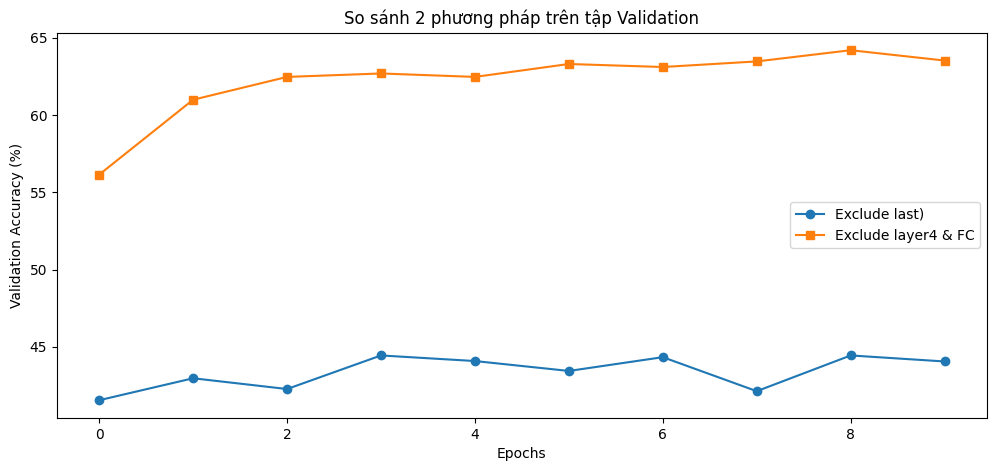

In [ ]:
# ------------- So sánh kết quả -------------
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(history1["val_acc"], label="Exclude last only", marker="o")
plt.plot(history2["val_acc"], label="Exclude layer4 & FC", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy (%)")
plt.title("So sánh 2 phương pháp trên tập Validation")
plt.legend()
plt.show()

In [16]:
test_dataset = FERDataset(x_test, y_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def evaluate_model(model, test_loader, device):
    """Đánh giá mô hình trên tập test"""
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = 100 * correct / total
    test_f1 = f1_score(all_labels, all_preds, average='macro')
    test_metric = 0.5 * (test_acc / 100 + test_f1)

    print(f"Test Accuracy: {test_acc:.2f}%, F1 Score: {test_f1:.4f}, Final Metric: {test_metric:.4f}")

    return test_acc, test_f1, test_metric

evaluate_model(model, test_loader, device)

Test Accuracy: 64.53%, F1 Score: 0.6324, Final Metric: 0.6389


(64.53050989133463, 0.6324211540634498, 0.638863126488398)